In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

In [94]:
training_set = pd.read_csv('./monthly-lake-erie-levels-1921-19.csv')
training_set = training_set.iloc[:,1:2].values

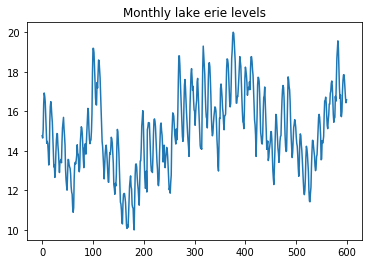

In [95]:
plt.plot(training_set)
plt.title('Monthly lake erie levels')
plt.show()

In [96]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

In [97]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

In [98]:
seq_length = 7
learning_rate = 0.01
input_size = 1
hidden_size = 5
num_classes = 1
num_layers = 1
num_epochs = 400

In [99]:
x , y = sliding_windows(training_set, seq_length)

In [100]:
train_size = int(len(y) * 0.7)
test_size = len(y) - training_set
trainX = torch.Tensor(np.array(x[0:train_size]))
trainX = Variable(trainX)

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testX = Variable(testX)

trainY = torch.Tensor(np.array(y[0:train_size]))
trainY = Variable(trainY)

testY = torch.Tensor(np.array(y[train_size:len(y)]))
testY = Variable(testY)

In [101]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [102]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [103]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.data[0]) )

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


Epoch: 0, loss: 0.11581
Epoch: 100, loss: 0.00919
Epoch: 200, loss: 0.00329
Epoch: 300, loss: 0.00289


In [104]:
lstm.eval()
test_predict = lstm(testX)

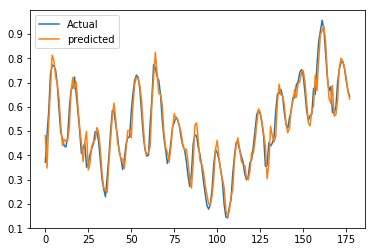

In [105]:
test_predict = test_predict.data.numpy()
testY = testY.data.numpy()
plt.plot(testY, label="Actual")
plt.plot(test_predict, label="predicted")
plt.legend()
plt.show()